In [1]:
from IPython.core.display import HTML, display
display(HTML('<style>.container {width:95% !important;} </style>'))

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

# Содержание
### [0. Импорт данных и разведочный анализ](#0-import)
### [1. Первая грубая модель](#1-mvp)

# 0. Импорт данных и разведочный анализ <a class="anchor" id="0-import"></a>

In [3]:
raw_data = pd.read_csv('housing.csv')

In [4]:
raw_data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [7]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [8]:
raw_data.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


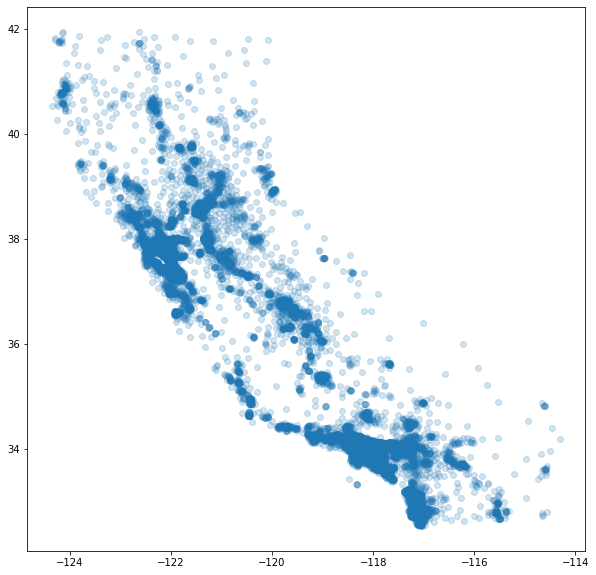

In [12]:
plt.figure(figsize= (10,10))
plt.scatter(raw_data.longitude, raw_data.latitude, alpha = 0.2)

# 1. Первая грубая модель <a class="anchor" id="1-mvp"></a>

In [19]:
s1_df = raw_data.copy()

In [20]:
s1_df['total_bedrooms'].fillna(raw_data['total_bedrooms'].mean(), inplace=True)

In [22]:
s1_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20640 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [29]:
s1_df = s1_df.select_dtypes(include=['float64'])

In [24]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [25]:
train_test_split?

In [34]:
mvp_columns = s1_df.columns.to_list()[:-1]

In [35]:
mvp_columns

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income']

In [37]:
X_mvp = pd.DataFrame(s1_df, columns=mvp_columns)

In [38]:
X_mvp

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462
...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672


In [39]:
y_mvp = s1_df.median_house_value

In [40]:
y_mvp

0        452600.0
1        358500.0
2        352100.0
3        341300.0
4        342200.0
           ...   
20635     78100.0
20636     77100.0
20637     92300.0
20638     84700.0
20639     89400.0
Name: median_house_value, Length: 20640, dtype: float64

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X_mvp, y_mvp, test_size = 0.3, random_state = 42)

In [42]:
X_train

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
7061,-118.02,33.93,35.0,2400.0,398.0,1218.0,408.0,4.1312
14689,-117.09,32.79,20.0,2183.0,534.0,999.0,496.0,2.8631
17323,-120.14,34.59,24.0,1601.0,282.0,731.0,285.0,4.2026
10056,-121.00,39.26,14.0,810.0,151.0,302.0,138.0,3.1094
15750,-122.45,37.77,52.0,3188.0,708.0,1526.0,664.0,3.3068
...,...,...,...,...,...,...,...,...
11284,-117.96,33.78,35.0,1330.0,201.0,658.0,217.0,6.3700
11964,-117.43,34.02,33.0,3084.0,570.0,1753.0,449.0,3.0500
5390,-118.38,34.03,36.0,2101.0,569.0,1756.0,527.0,2.9344
860,-121.96,37.58,15.0,3575.0,597.0,1777.0,559.0,5.7192


In [43]:
X_test

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
20046,-119.01,36.06,25.0,1505.0,537.870553,1392.0,359.0,1.6812
3024,-119.46,35.14,30.0,2943.0,537.870553,1565.0,584.0,2.5313
15663,-122.44,37.80,52.0,3830.0,537.870553,1310.0,963.0,3.4801
20484,-118.72,34.28,17.0,3051.0,537.870553,1705.0,495.0,5.7376
9814,-121.93,36.62,34.0,2351.0,537.870553,1063.0,428.0,3.7250
...,...,...,...,...,...,...,...,...
17505,-121.90,37.36,47.0,1007.0,245.000000,581.0,240.0,2.9545
13512,-117.32,34.11,41.0,1229.0,302.000000,994.0,270.0,1.4891
10842,-117.91,33.67,16.0,7961.0,2276.000000,5014.0,2116.0,3.5120
16559,-121.28,37.82,10.0,9205.0,1774.000000,5935.0,1673.0,3.6500


In [45]:
model = Ridge()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)

In [49]:
print('train RMSE ', mean_squared_error(y_train, y_pred_train, squared=False))
print('test RMSE', mean_squared_error(y_test, y_pred, squared=False))

train RMSE  69750.66614003474
test RMSE 69656.61990029787


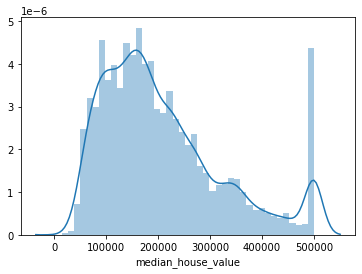

In [50]:
sns.distplot(y_train)